In [2]:
import gooseberry as gs

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import jax
import jax.numpy as jnp

from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

In [3]:
def logs(params, X, Y, out_dim):
    w1 = params["network"]["layer-0"]["w"][0]
    w2 = params["network"]["layer-1"]["w"][0]
    ni, no = w1.shape[1], w2.shape[0]
    w2w1 = w2 @ w1
    w1w1 = w1.T @ w1
    w2w2 = w2 @ w2.T
    ntk = jnp.kron(jnp.identity(no), X @ (w1.T @ w1) @ X.T) + jnp.kron(w2 @ w2.T, X @ X.T)
    return w2w1, w1w1, w2w2, ntk

logs = jax.jit(logs)

In [4]:
blind_colours = BlindColours().get_colours()

In [5]:
def balanced_weights(in_dim, hidden_dim, out_dim, c):
    w1 = np.eye(hidden_dim, in_dim) * np.sqrt(c + 1)
    w2 = np.eye(out_dim, hidden_dim)

    return w1, w2

In [6]:
np.random.seed(3)

in_dim = 4
hidden_dim = 5
out_dim = 3

batch_size = 10
learning_rate = 0.05
training_steps = 1000

network_functions = []
w1w1s = []
w2w2s = []
ntks = []
lossess = []
analyticalss = []

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .25)
# init_w1, init_w2 = balanced_weights(in_dim, hidden_dim, out_dim, c=10)
training_data, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])
X, Y = training_data(None)

for initial_weight_scale in [0.001, 0.15, -1]:
    print(initial_weight_scale)
    network_function = []
    w1w1 = []
    w2w2 = []
    ntk = []
    losses = []
    analyticals = np.zeros((training_steps, in_dim + out_dim, in_dim + out_dim))

    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    if initial_weight_scale != -1:
        init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_weight_scale)

    else:
        init_w1, init_w2 = balanced_weights(in_dim, hidden_dim, out_dim, c=5)


    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    w1 = params["network"]["layer-0"]["w"][0]
    w2 = params["network"]["layer-1"]["w"][0]
    ni, no = w1.shape[1], w2.shape[0]
    network_function.append(w2 @ w1)
    w1w1.append(w1.T @ w1)
    w2w2.append(w2 @ w2.T)
    ntk.append(jnp.kron(jnp.identity(no), X @ (w1.T @ w1) @ X.T) + jnp.kron(w2 @ w2.T, X @ X.T))

    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        w2w1_, w1w1_, w2w2_, ntk_ = logs(params, X, Y, out_dim)
        network_function.append(w2w1_)
        w1w1.append(w1w1_)
        w2w2.append(w2w2_)
        ntk.append(ntk_)
        losses.append(loss)
    analytical = QQT(init_w1, init_w2, X.T, Y.T)
    
    for step in range(training_steps):
        analyticals[step] = analytical.forward(learning_rate)
    

    lossess.append(np.asarray(losses))
    network_functions.append(np.asarray(network_function))
    w1w1s.append(np.asarray(w1w1))
    w2w2s.append(np.asarray(w2w2))
    ntks.append(np.asarray(ntk))
    analyticalss.append(analyticals)

0.001
0.15
-1


In [14]:
lossess

[array([[1.1538674e+00],
        [1.1538644e+00],
        [1.1538616e+00],
        ...,
        [6.3432132e-13],
        [6.3432132e-13],
        [6.3432132e-13]], dtype=float32),
 array([[1.3380297e+00],
        [1.2651585e+00],
        [1.2020354e+00],
        ...,
        [5.4420173e-13],
        [5.4360834e-13],
        [5.4359723e-13]], dtype=float32),
 array([[7.2941980e+00],
        [3.2178857e+00],
        [1.6121932e+00],
        ...,
        [1.9246938e-14],
        [1.9246938e-14],
        [1.9246938e-14]], dtype=float32)]

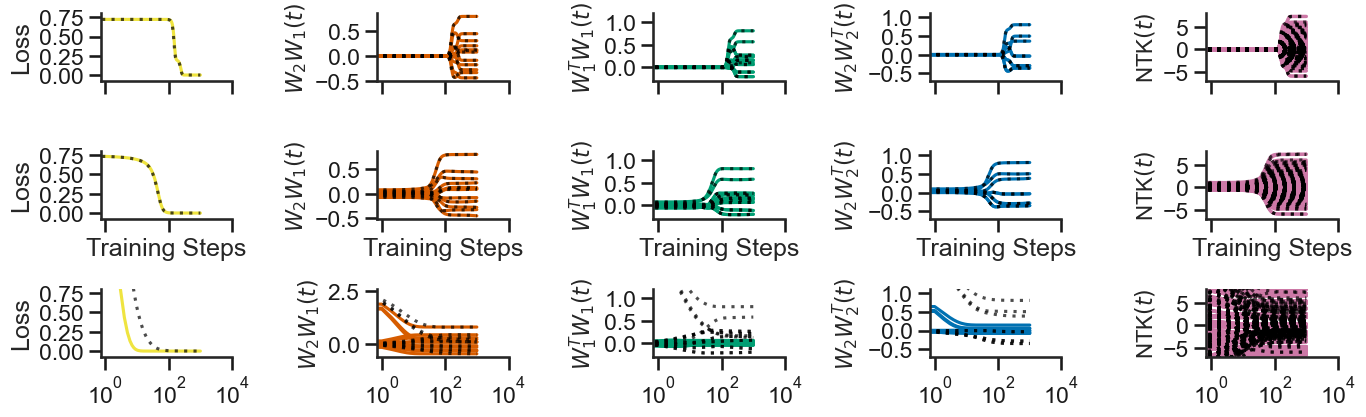

In [7]:
fig, axs_ = plt.subplots(3, 5, figsize=(14, 4.5), sharex=True)

for mode in range(3):
    axs = axs_[mode]
    # print(mode, network_functions[mode][0][0])
    axs[1].plot(network_functions[mode].reshape(-1, in_dim * out_dim), color=blind_colours[0])
    w2w1 = analyticalss[mode][:, in_dim:, :in_dim]
    axs[1].plot(w2w1.reshape(-1, in_dim * out_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    #axs[1].set_ylim(-0.38, 0.3)
    #axs[1].set_yticks([ -0.2, 0., 0.2])
    axs[1].set_ylabel("$W_2W_1(t)$", fontsize=16)
    
    axs[0].plot(lossess[mode], color=blind_colours[6])
    loss = []
    loss = 0.5 * (out_dim / batch_size) * np.mean(np.sum((w2w1 @ X.T - Y.T)**2, axis=2), axis=1)
    axs[0].plot(loss, c="k", alpha=0.7, linestyle=(0, (1, 2)))
    axs[0].set_ylim(-0.075, 0.8)
    axs[0].set_yticks([0., 0.25, 0.5, 0.75])
    axs[0].set_ylabel("Loss")
    
    
    axs[2].plot(w1w1s[mode].reshape(-1, in_dim * in_dim), color=blind_colours[2])
    w1w1 = analyticalss[mode][:, :in_dim, :in_dim]
    axs[2].plot(w1w1.reshape(-1, in_dim * in_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    axs[2].set_ylim(-0.3, 1.2)
    axs[2].set_yticks([0., 0.5, 1.])
    axs[2].set_ylabel("$W_1^TW_1(t)$", fontsize=16)
    
    axs[3].plot(w2w2s[mode].reshape(-1, out_dim * out_dim), color=blind_colours[1])
    w2w2 = analyticalss[mode][:, in_dim:, in_dim:]
    axs[3].plot(w2w2.reshape(-1, out_dim * out_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    axs[3].set_ylim(-0.7, 1.1)
    axs[3].set_yticks([-0.5, 0., 0.5, 1.])
    axs[3].set_ylabel("$W_2W_2^T(t)$", fontsize=16)
    
    axs[4].plot(ntks[mode].reshape(-1, out_dim*batch_size * out_dim*batch_size), color=blind_colours[3])
    
    ntk = np.kron(np.identity(out_dim), np.einsum("ab,cbd,de->cae", X, w1w1, X.T)) + np.kron(w2w2, X@X.T) #  + np.einsum("a,bc,cd->abd", np.trace(, axis1=1, axis2=2), X, X.T)
    axs[4].plot(ntk.reshape(-1, out_dim*batch_size * out_dim*batch_size), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    axs[4].set_ylabel("NTK$(t)$", fontsize=16)
    axs[4].set_ylim(-7, 8)
    axs[4].set_yticks([-5, 0, 5])
    
    if mode == 1:
        for i in range(5):
            axs[i].set_xlabel("Training Steps")
    axs[0].set_xscale("log")
    axs[0].set_xticks([1., 100, 10000])
sns.despine()
fig.tight_layout()

fig.savefig("./figures/figure-2_a-b.svg")

In [13]:
len(network_functions)

2

In [59]:
loss = lossess[2]

In [60]:
loss[-10:]

array([[5.6468718e-15],
       [5.6468718e-15],
       [5.6468718e-15],
       [5.6468718e-15],
       [5.6468718e-15],
       [5.6468718e-15],
       [5.6468718e-15],
       [5.6468718e-15],
       [5.6468718e-15],
       [5.6468718e-15]], dtype=float32)

In [ ]:
"""
TODO: test rates of convergence of loss function, see if we agree with the paper

"""
